# ANN Coursework - ResNet50 Technique

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
import glob
import csv
import numpy as np
import pandas as pd
import os
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
import pathlib
from IPython.display import Image, display
import os, random

In [2]:
data_train = r"C:\Users\giorg\Jupyter notebooks\Artificial Neural Networks_CW\BrainTumor\Training"
data_test = r"C:\Users\giorg\Jupyter notebooks\Artificial Neural Networks_CW\BrainTumor\Testing"

path_train = pathlib.Path(data_train)
path_test = pathlib.Path(data_test)

print(path_train)
image_count_train = len(list(path_train.glob('*/*.jpg')))
print(image_count_train)

print(path_test)
image_count_test = len(list(path_test.glob('*/*.jpg')))
print(image_count_test)

C:\Users\giorg\Jupyter notebooks\Artificial Neural Networks_CW\BrainTumor\Training
2870
C:\Users\giorg\Jupyter notebooks\Artificial Neural Networks_CW\BrainTumor\Testing
394


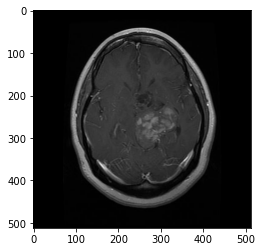

In [3]:
categories = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

for category in categories:
    path_tr = os.path.join(path_train,category) # this will map the training path folders to the particular category
  

 # read the image as an array
    
    for img in os.listdir(path_tr):
        img_array_tr = cv2.imread(os.path.join(path_tr,img)) 
        plt.imshow(img_array_tr)
        plt.show()
        break
    break

(-0.5, 127.5, 127.5, -0.5)

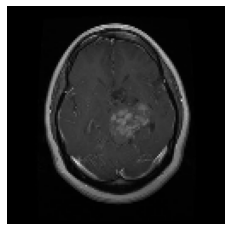

In [4]:
img_size = 128 # we want to convert all our images to have the same size (some might had different sizes)

array1 = cv2.resize(img_array_tr,(img_size, img_size)) # resizing all the images
plt.imshow(array1, cmap ="gray")
plt.axis("off")

In [5]:
train_tumor = []

for i in categories:
    train_path = os.path.join(data_train,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_tumor.append([new_image_array , tag]) # so the train tumor will consist of the images and the categories 
        except Exception as e:
            pass

In [6]:
X_train = []
y_train = []
for i,j in train_tumor:
    X_train.append(i) # i is basically the images
    y_train.append(j) # is basically the categories
    
X_train = np.array(X_train).reshape(-1,img_size,img_size) #transform the image into array so as the computer can read them and reshape it
print(X_train.shape)                                      # the -1 indicates that we now have a 1 dimensional array

X_train = X_train/255.0 # we devide with 255.0 because the pixel intensity lies between 0 - 255 for mathematical simplification
X_train = X_train.reshape(-1,128,128,1)

(2870, 128, 128)


In [7]:
test_tumor = []

for i in categories:
    test_path = os.path.join(data_test,i)
    tag = categories.index(i)
    for img in os.listdir(test_path):
        try:
            image_arr = cv2.imread(os.path.join(test_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            test_tumor.append([new_image_array , tag]) # so the train tumor will consist of the images and the categories 
        except Exception as e:
            pass

In [8]:
X_test = []
y_test = []
for i,j in test_tumor:
    X_test.append(i) # i is basically the images
    y_test.append(j) # is basically the categories
    
X_test = np.array(X_test).reshape(-1,img_size,img_size) #transform the image into array so as the computer can read them and reshape it
print(X_test.shape)                                      # the -1 indicates that we now have a 1 dimensional array

X_test = X_test/255.0 # we devide with 255.0 because the pixel intensity lies between 0 - 255 for mathematical simplification
X_test = X_test.reshape(-1,128,128,1)

(394, 128, 128)


In [9]:
# convert the brain tumor categories into numbers using one-hot-encoding

y_train = to_categorical(y_train, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

In [10]:
# our dataset is already split into train-test, so we just need to also use some data for validation

X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 128, 128, 1)
x_test shape (574, 128, 128, 1)
y_train shape (2296, 4)
y_test shape (574, 4)


In [12]:
data_generator = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range = 0.4,
                                   height_shift_range = 0.4,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   )

#image_size = 128
batch_size = 40
train_generator = data_generator.flow_from_directory(data_train,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

#num_classes = len(train_generator.class_indices)

Found 2870 images belonging to 4 classes.


# Model Creation

In [13]:
resnet_model = Sequential()

resnet_model.add(ResNet50(include_top=False, pooling='avg', weights=None)) # check the weights
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(4, activation='softmax'))

resnet_model.layers[0].trainable = False

In [14]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4

In [17]:
history = resnet_model.fit(
        train_generator,
        steps_per_epoch=57,
        epochs=2)

Epoch 1/2
57/57 [==============================] - 70s 1s/step - loss: 1.2586 - accuracy: 0.4626
Epoch 2/2
57/57 [==============================] - 71s 1s/step - loss: 1.2318 - accuracy: 0.4575


# Model Evaluation

In [21]:
[test_loss, test_acc] = resnet_model.evaluate(X_test, y_test, verbose=1)

print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

ValueError: in user code:

    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1183 test_step
        y_pred = self(x, training=False)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\giorg\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv1_conv is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (None, 134, 134, 1)


In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(history.history['accuracy'],'r',linewidth=3.0) 
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
from IPython.display import Image, display

import os, random
img_locations = []
for d in os.listdir(r"C:/Users/giorg/Jupyter notebooks/Artificial Neural Networks_CW\BrainTumor/Training"):
    directory = r"C:/Users/giorg/Jupyter notebooks/Artificial Neural Networks_CW/BrainTumor/Training/" + d
    sample = [directory + '/' + s for s in random.sample(
        os.listdir(directory), int(random.random()*10))]
    img_locations += sample

In [ ]:
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

random.shuffle(img_locations)
imgs = read_and_prep_images(img_locations)
predictions = resnet_model.predict_classes(imgs)
classes = dict((v,k) for k,v in train_generator.class_indices.items())

for img, prediction in zip(img_locations, predictions):
    display(Image(img))
    print(classes[prediction])